# Testing generative framework for fusing datasets

This jupyter notebook is to test the generative framework is able to learn multiple datasets simultaneously.

<br>

## Generate true data from markov random field

First, we generate some true individual parcellations $U$s given by a prior. We can fine-tuning the parameters to control how smooth the parcel boundaries are and the individual variablities.

<br>

In [14]:
# dependencies
%load_ext autoreload
%autoreload 2 
import os
import sys 
sys.path.append(os.path.abspath('..'))

import numpy as np
import torch as pt
import matplotlib.pyplot as plt

from full_model import FullModel
import emissions as em
import arrangements as ar
import spatial as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plotting the group prior

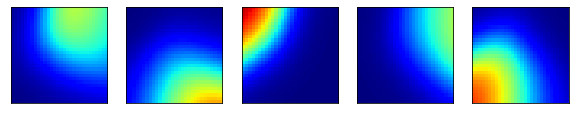

In [15]:
K=5
N=20
num_sub=10
max_iter=100
sigma2=20
width = 30
height = 30

# Step 1: Create the true model
grid = sp.SpatialGrid(width=width, height=height)
arrangeT = ar.PottsModel(grid.W, K=K, remove_redundancy=False)
emissionT1 = em.MixVMF(K=K, N=N, P=grid.P, uniform_kappa=True)
emissionT1.kappa = pt.tensor(sigma2)
emissionT2 = em.MixVMF(K=K, N=N, P=grid.P, uniform_kappa=True)
emissionT2.kappa = pt.tensor(sigma2)

# Step 2: Initialize the parameters of the true model
arrangeT.random_smooth_pi(grid.Dist, theta_mu=150)
arrangeT.theta_w = pt.tensor(20)

# Step 3: Plot the prior of the true mode
plt.figure(figsize=(10, 4))
grid.plot_maps(pt.exp(arrangeT.logpi), cmap='jet', vmax=1, grid=[1, K])

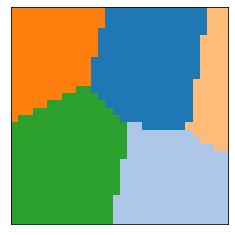

In [16]:
cluster = np.argmax(arrangeT.logpi, axis=0)
grid.plot_maps(cluster, cmap='tab20')

### Sample true individual parcellations

Here, we generate the true individual parcellations for 10 subjects given by the group prior. In our simulation, we make the boundaries relatively smooth and more individual varibilities. The 10 subjects are splitted into two datasets, the first one contains 3 subjects and the second dataset has 7 subjects.

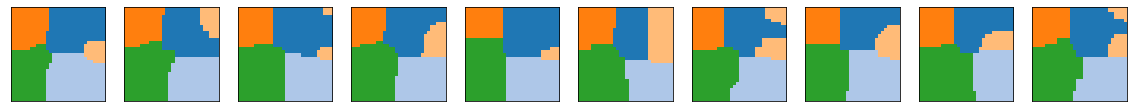

In [17]:
# Step 4: Generate data by sampling from the above model
import full_model as fm

D = []
ns = [3, 7]
T = fm.FullMultiModel(arrangeT, [emissionT1, emissionT2])

U, Y_train = T.sample(num_subj=ns)
num_sub = sum(ns)

plt.figure(figsize=(20, 2))
grid.plot_maps(U, cmap='tab20', vmax=19, grid=[1, int(num_sub)])

### Generate multiple datasets for fusing

Here, `Y_train` is a list of different datasets given by the number of subjects for the datasets.

In [18]:
# Step 6: Generate new models for fitting
arrangeM = ar.ArrangeIndependent(K=K, P=grid.P, spatial_specific=True, remove_redundancy=False)
emissionM1 = em.MixVMF(K=K, N=N, P=grid.P, uniform_kappa=True)
emissionM2 = em.MixVMF(K=K, N=N, P=grid.P, uniform_kappa=True)

# set params of recovery model to truth
arrangeM.logpi = T.arrange.logpi

### How to escape from the local maxima?

Here, we use the traditional EM routine to fusing multiple dataset. But the log-likelihood could traped in the local maxima as show below. The first `n=3` subjects from dataset 1 has the label misalignment witht the rest `n=7` subjects from the dataset 2. 

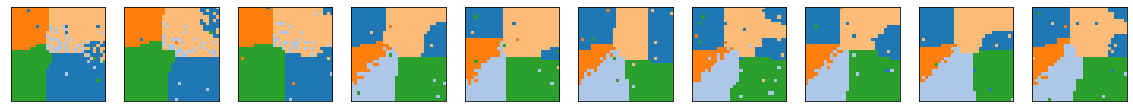

In [19]:
M = fm.FullMultiModel(arrangeM, [emissionM1, emissionM2])
M, ll, theta, Uhat_fit, f_lls = M.fit_em_ninits(Y=Y_train, n_inits=1, iter=max_iter, tol=0.001, fit_arrangement=False)

# for i in range(len(f_lls)):
#     plt.plot(f_lls[i])
# # plt.ylim(-20000, 0)

plt.figure(figsize=(20, 2))
grid.plot_maps(pt.argmax(Uhat_fit, dim=1), cmap='tab20', vmax=19, grid=[1, int(num_sub)])

### Strategy 1: giving multiple initilizations and continue learning the model upon the maximum loglikelihood

The first strategy to escape from the local maxima is to give many starting parameters, in this case `n_inits=50`, and find the parameters with the maximum log-likelihood among this initilization sets. Then continue learning the full models start with this parameters. 

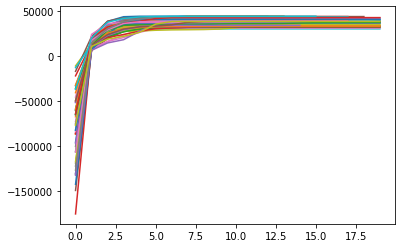

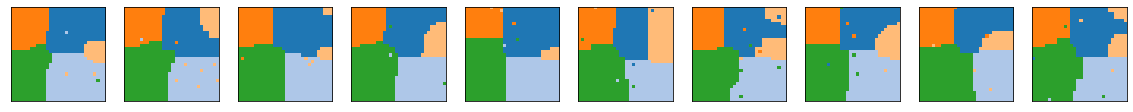

In [20]:
M = fm.FullMultiModel(arrangeM, [emissionM1, emissionM2])
M, ll, theta, Uhat_fit, f_lls = M.fit_em_ninits(Y=Y_train, n_inits=50, iter=max_iter, tol=0.001, fit_arrangement=False)

for i in range(len(f_lls)):
    plt.plot(f_lls[i])
# plt.ylim(-20000, 0)

plt.figure(figsize=(20, 2))
grid.plot_maps(pt.argmax(Uhat_fit, dim=1), cmap='tab20', vmax=19, grid=[1, int(num_sub)])

As we can see here, the predicted $\hat{\mathbf{U}}$ is now totally aligned with the ground truth. This is because the model converged to the global maxima.

**Drawback** - The performance of this strategy is subject to the choice of the number of initilizations and the first few iterations to determine the parameters which continue learning. So if we set a small number of initilizations, the resultant could still a local maxima. As shown below.

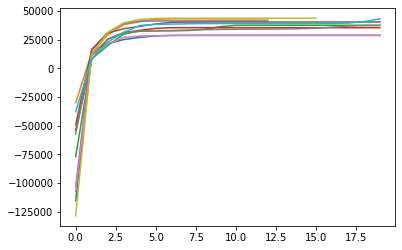

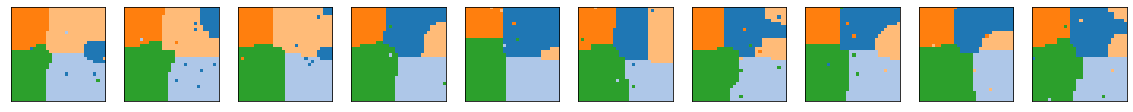

In [21]:
M = fm.FullMultiModel(arrangeM, [emissionM1, emissionM2])
M, ll, theta, Uhat_fit, f_lls = M.fit_em_ninits(Y=Y_train, n_inits=10, iter=max_iter, tol=0.001, fit_arrangement=False)

for i in range(len(f_lls)):
    plt.plot(f_lls[i])
# plt.ylim(-20000, 0)

plt.figure(figsize=(20, 2))
grid.plot_maps(pt.argmax(Uhat_fit, dim=1), cmap='tab20', vmax=19, grid=[1, int(num_sub)])

### Strategy 2: Initilizing the emission models parameters from a prior

An alternative enchanced method, possibly the best solution, is to generate the starting value from a rough group prior learnt from one or multiple dataset. Then we use this starting parameters to train the generative model. In this case, the model is garantteed to converge to the global maxima and we just initilize one time.

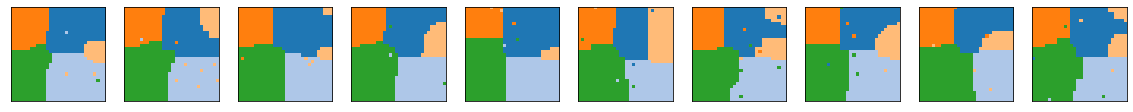

In [22]:
# Method 1: escape local maxima by inits from prior
M = fm.FullMultiModel(arrangeM, [emissionM1, emissionM2])

M.pre_train(Y_train, iter=20)
M, ll, theta, Uhat_fit = M.fit_em(Y=Y_train, iter=max_iter, tol=0.001, fit_arrangement=False)

plt.figure(figsize=(20, 2))
grid.plot_maps(pt.argmax(Uhat_fit, dim=1), cmap='tab20', vmax=19, grid=[1, int(num_sub)])

As we can see here, the cluster labels from the $\hat{U}$ are already aligned across subjects, Then we perform cluster matching with the ground true $U$s and compare then.

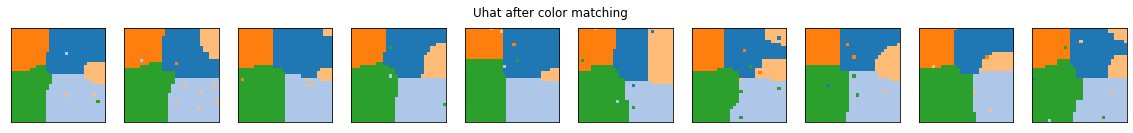

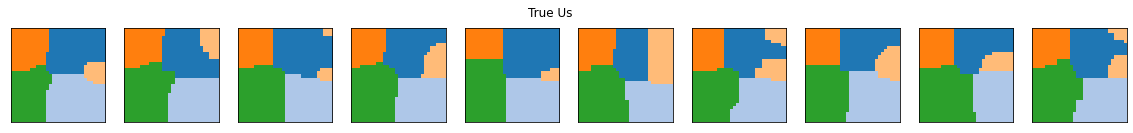

In [23]:
import evaluation as ev
Uhat_fit_matched, U_err = ev.matching_U(U, Uhat_fit)

plt.figure(figsize=(20, 2))
grid.plot_maps(Uhat_fit_matched, cmap='tab20', vmax=19, grid=[1, int(num_sub)])
plt.suptitle("Uhat after color matching")
plt.show()

plt.figure(figsize=(20, 2))
grid.plot_maps(U, cmap='tab20', vmax=19, grid=[1, int(num_sub)])
plt.suptitle("True Us")
plt.show()

## Simulate data fusion on different dataset with different tasks (boundaries are varying)

First, we generate two different dataset from $U$s with different task set, which means the underlying boundaries learnt from each dataset could be varying. i.g dataset 1 focuses on motor-related tasks while dataset 2 focuses on visual tasks. Therefore, both two datasets have limited coverage.

In this experiment, we simulate above situation and let dataset1 with `subjects=4, tasks=40` and dataset2 with `subjects=6, tasks=20`. Then we randomly select two adjacent clusters from the true $\mathbf{U}$ and let the true emission models have the same $\mathbf{v}_k$ of these two regions.

tensor(3) tensor([0])
tensor(0) tensor([1])


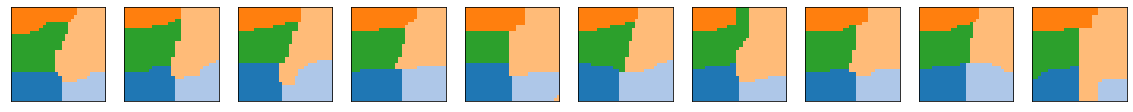

In [72]:
from simulate_dataFusion import _compute_adjacency
ns = [4, 6]

grid = sp.SpatialGrid(width=width, height=height)
arrangeT = ar.PottsModel(grid.W, K=K, remove_redundancy=False)
arrangeT.random_smooth_pi(grid.Dist, theta_mu=120)
arrangeT.theta_w = pt.tensor(20)

emissionT1 = em.MixVMF(K=K, N=40, P=grid.P, uniform_kappa=True)
emissionT1.kappa = pt.tensor(sigma2)
emissionT2 = em.MixVMF(K=K, N=20, P=grid.P, uniform_kappa=True)
emissionT2.kappa = pt.tensor(sigma2)
    
# Making ambiguous boundaries by set the same V_k for two parcels
label_map = pt.argmax(arrangeT.logpi, dim=0).reshape(grid.dim)
_, base, idx = _compute_adjacency(label_map, 2)
print(base, idx)
for i in idx:
    emissionT1.V[:, i] = emissionT1.V[:, base]

_, base, idx = _compute_adjacency(label_map, 2)
print(base, idx)
for i in idx:
    emissionT2.V[:, i] = emissionT2.V[:, base]
    
T = fm.FullMultiModel(arrangeT, [emissionT1, emissionT2])
U, Y_train = T.sample(num_subj=ns)

plt.figure(figsize=(20, 2))
grid.plot_maps(U, cmap='tab20', vmax=19, grid=[1, 10])

In [73]:
arrangeM = ar.ArrangeIndependent(K=K, P=grid.P, spatial_specific=True,remove_redundancy=False)
emissionM1 = em.MixVMF(K=K, N=40, P=grid.P, uniform_kappa=True)
emissionM2 = em.MixVMF(K=K, N=20, P=grid.P, uniform_kappa=True)

# set params of recovery model to truth
arrangeM.logpi = T.arrange.logpi
M1 = fm.FullModel(arrangeM, emissionM1)
M2 = fm.FullModel(arrangeM, emissionM2)
M = fm.FullMultiModel(arrangeM, [emissionM1, emissionM2])

# Train each dataset separately
M1, ll, theta, Uhat_fit_1 = M1.fit_em(Y=Y_train[0], iter=200, tol=0.001, fit_arrangement=True)
M2, ll, theta, Uhat_fit_2 = M2.fit_em(Y=Y_train[1], iter=200, tol=0.001, fit_arrangement=True)
# Method 1: escape local maxima by inits from prior
M.pre_train(Y_train, iter=20)
M, ll, theta, Uhat_fit = M.fit_em(Y=Y_train, iter=200, tol=0.001, fit_arrangement=True)

### Learning standalone on dataset 1 

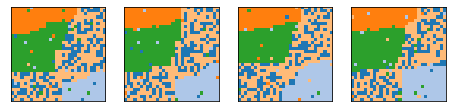

In [74]:
Uhat_fit_1_match, err1 = ev.matching_U(U[0:4], Uhat_fit_1)
plt.figure(figsize=(20, 2))
grid.plot_maps(Uhat_fit_1_match, cmap='tab20', vmax=19, grid=[1, 10])

### Learning standalone on dataset 2

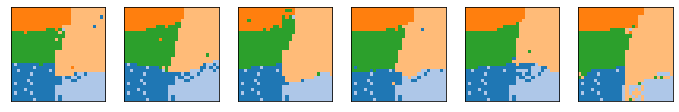

In [75]:
Uhat_fit_2_match, err2 = ev.matching_U(U[4:10], Uhat_fit_2)
plt.figure(figsize=(20, 2))
grid.plot_maps(Uhat_fit_2_match, cmap='tab20', vmax=19, grid=[1, 10], offset=5)

### Learning on dataset fusion on both dataset 1 and 2

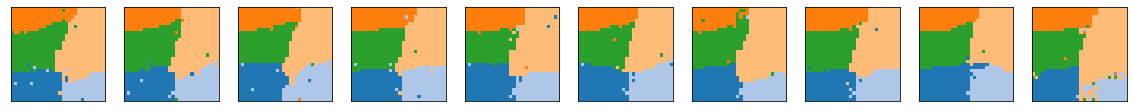

In [76]:
Uhat_fit_match, err = ev.matching_U(U, Uhat_fit)
plt.figure(figsize=(20, 2))
grid.plot_maps(Uhat_fit_match, cmap='tab20', vmax=19, grid=[1, 10])

Text(0, 0.5, 'Absolute error between $\\mathbf{U}$ and $\\hat{\\mathbf{U}}$')

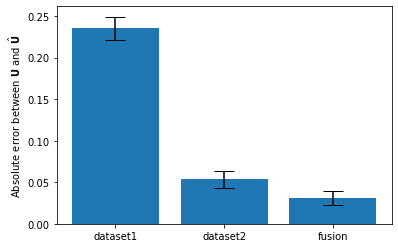

In [77]:
plt.bar(['dataset1', 'dataset2', 'fusion'], [err1.mean(), err2.mean(),err.mean()],
        yerr=[err1.std(), err2.std(), err.std()], capsize=10)
plt.ylabel(r'Absolute error between $\mathbf{U}$ and $\hat{\mathbf{U}}$')